In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import math

In [20]:
csv_list = []
resources = [1, 2, 4, 8]

time_taken = []
tput = []

for i in resources:
    csv_list.append(
        pd.read_csv(
            f"cluster_logs/{i}+{i}_image_inference_s3_batch_128_100pct.csv"
        )
    )

for csv_file in csv_list:
    time_taken.append(csv_file.iloc[-1]["time_from_start"])
    tput.append(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

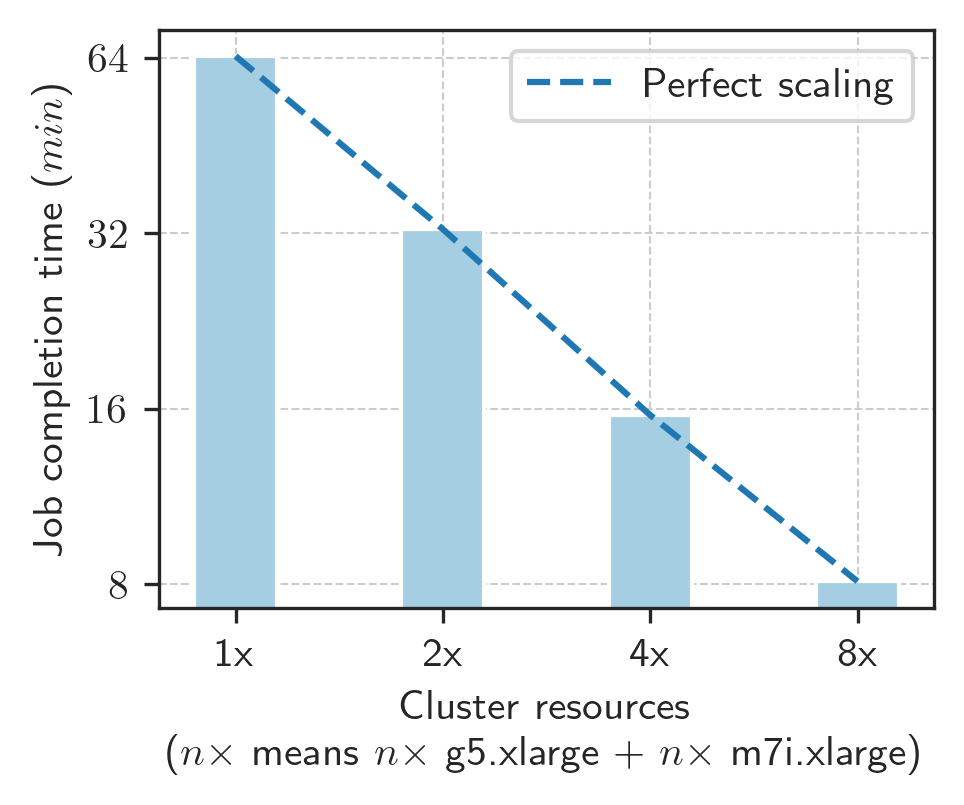

In [21]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

resources_idx = np.arange(len(resources))
time_taken_hours = [t / 60 for t in time_taken]

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

bars = ax.bar(resources_idx, time_taken_hours, color=COLORS[0], width=0.4)

ax.plot(resources_idx, time_taken_hours, linestyle="--", color=COLORS[1], label="Perfect scaling")

ax.set_xlabel("Cluster resources\n($n\\times$ means $n\\times$ g5.xlarge + $n\\times$ m7i.xlarge)")
ax.set_ylabel("Job completion time ($min$)")

ax.set_yscale("log")
ax.yaxis.set_minor_locator(ticker.NullLocator())
y_ticks = [
    2**i
    for i in range(
        int(math.log(min(time_taken_hours), 2)), int(math.log(max(time_taken_hours), 2)) + 1
    )
]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"${int(y)}$" for y in y_ticks])
ax.set_xticks(resources_idx, [f"{x}x" for x in resources])

ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.legend()
plt.savefig("image-scaling.pdf", bbox_inches="tight")

In [30]:
BATCH_SIZE = 128
DATA_PERCENTAGE = 100
COMPUTE = "1+1"
s3_0_1 = pd.read_csv(
    f"logs/csv/single_image_inference_s3_map_batches_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)

s3_1_1 = pd.read_csv(
    f"cluster_logs/{COMPUTE}_image_inference_s3_batch_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/csv/image_inference_s3_map_batches_128_blocks_130000_100pct.csv'

In [29]:
def process_single(data, resample="50s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    avg_tput = np.mean(data["batch_throughput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["batch_throughput"].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput


def process_11(data, resample="50s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [24]:
idx_s3_0_1, values_s3_0_1, avg_single = process_single(s3_0_1)
print("Single node avg tput: ", avg_single)

idx_s3_1_1, values_s3_1_1, avg_s3 = process_11(s3_1_1)
print("1+1 avg tput: ", avg_s3)

Single node avg tput:  342.6955584088864
1+1 avg tput:  403.7154585356676


In [25]:
flink_data = pd.read_csv("cluster_logs/flink_inference.csv")
idx_flink, values_flink, avg_flink = process_single(flink_data)
print("Flink avg tput: ", avg_flink)

Flink avg tput:  43.87296198548095


In [26]:
theoretical_s3 = np.mean(s3_0_1["batch_inference_throughput"])
print("S3 avg theoretical: ", theoretical_s3)

S3 avg theoretical:  438.50079871784334


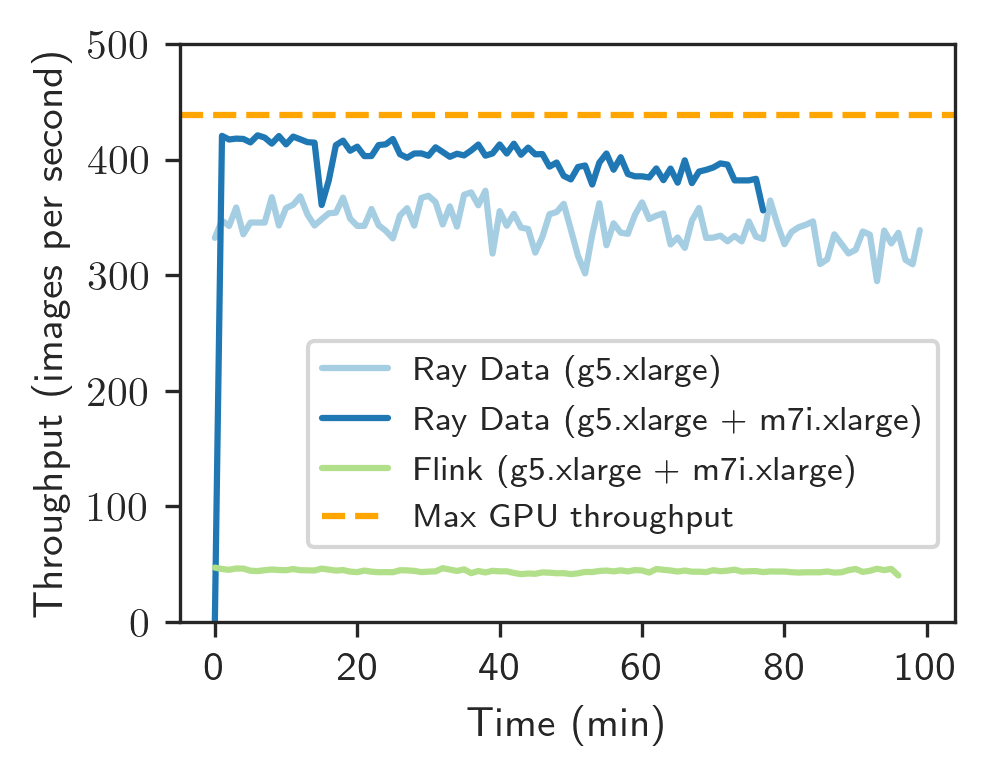

In [27]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10
COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_0_1, values_s3_0_1, label="Ray Data (g5.xlarge)")
ax.plot(idx_s3_1_1, values_s3_1_1, label="Ray Data (g5.xlarge + m7i.xlarge)")
ax.plot(idx_flink, values_flink, label="Flink (g5.xlarge + m7i.xlarge)")


ax.axhline(y=theoretical_s3, color="orange", linestyle="--", label="Max GPU throughput")

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xticks([0, 20, 40, 60, 80, 100])
plt.gca().set_xticklabels(["0", "20", "40", "60", "80", "100"])

plt.xlabel("Time (min)")
plt.ylabel("Throughput (images per second)")
plt.ylim(0, 500)
plt.legend(fontsize=8, loc="lower right", bbox_to_anchor=(1, 0.1))
plt.savefig("image-tput.pdf", bbox_inches="tight")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [135]:
BATCH_SIZE = 128
DATA_PERCENTAGE = 100
COMPUTE = "1+1"
single_s3 = pd.read_csv(
    f"logs/csv/single_image_inference_s3_map_batches_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)
onePone_s3 = pd.read_csv(
    f"{COMPUTE}_image_inference_s3_batch_{BATCH_SIZE}_{DATA_PERCENTAGE}pct.csv"
)

In [142]:
def process_single(data, resample="30s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    avg_tput = np.mean(data["batch_throughput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["batch_throughput"].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [143]:
def process(data, resample='30s'):
    data = data.copy()
    data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
    data.set_index('time_from_start', inplace=True)
    data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
    data['tput'] = data['tput'].fillna(0)
    avg_tput = np.mean(data['tput'])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data['tput'].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [144]:
idx_single, values_single, avg_single = process_single(single_s3)
print("Single node avg tput: ", avg_single)

idx_s3, values_s3, avg_s3 = process(onePone_s3)
print("1+1 avg tput: ", avg_s3)

Single node avg tput:  342.6955584088864
1+1 avg tput:  403.7154585356676


In [145]:
theoretical_s3 = np.mean(single_s3["batch_inference_throughput"])
print("S3 avg theoretical: ", theoretical_s3)

S3 avg theoretical:  438.50079871784334


In [146]:
from datetime import datetime, timedelta

start_time = 1714778578.9191868

oom_times = [
    1714779348.5611486,
    1714779666.5738022,
    1714779887.6867087,
    1714780076.449717,
    1714780758.6991284,
    1714781065.3121893,
    1714781237.1936095,
    1714781648.8789914,
    1714781976.1444569,
]

oom_times = [str(timedelta(seconds=int(time - start_time))) for time in oom_times]
oom_times = [time[:5] + "00" for time in oom_times]
oom_times

['0:12:00',
 '0:18:00',
 '0:21:00',
 '0:24:00',
 '0:36:00',
 '0:41:00',
 '0:44:00',
 '0:51:00',
 '0:56:00']

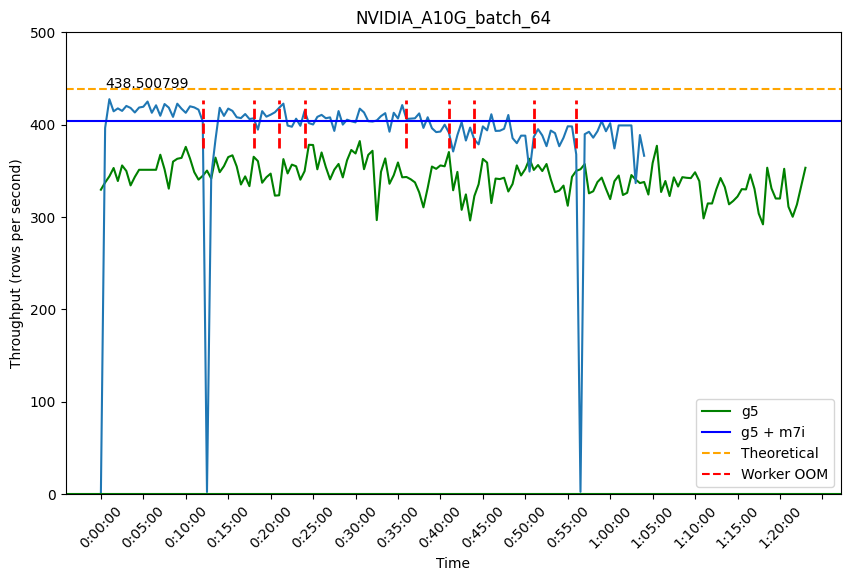

In [153]:
from datetime import datetime, timedelta

plt.figure(figsize=(10, 6))

plt.plot(idx_single, values_single, color="green")
plt.plot(idx_s3, values_s3)

plt.axhline(color="green", label="g5")  ## to fix
plt.axhline(y=avg_s3, color="b", label="g5 + m7i")  ## to fix
plt.axhline(y=theoretical_s3, color="orange", linestyle="--", label="Theoretical")  ## to fix


y_min = 360
y_max = 410
for time in oom_times:
    plt.axvline(
        x=time,
        ymin=y_min / 480,
        ymax=y_max / 480,
        color="r",
        linestyle="--",
        linewidth=2,
    )

plt.plot([], [], "r--", label="Worker OOM")

plt.text(1, theoretical_s3 + 1, f"{np.round(theoretical_s3, 6)}", color="black")

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.xlabel("Time")
plt.ylabel("Throughput (rows per second)")
plt.ylim(0, 500)
plt.title("NVIDIA_A10G_batch_64")
plt.legend()
plt.show()

In [115]:
values_s3

array([  0.        ,   0.        , 396.35307012, 430.45734383,
       415.37662274, 417.03784805, 418.61931881, 414.25971183,
       415.57565373, 422.86797681, 411.91262625, 421.90619348,
       420.01536854, 401.26371904, 424.96647226, 424.07246655,
       409.53661522, 431.97884749, 429.47634385, 406.43970013,
       419.76480201, 407.05257899, 421.17998936, 419.20048189,
       417.52019492, 417.53552662, 404.75350268, 425.1309148 ,
       424.9043731 , 408.84481967, 406.01576973, 426.55483621,
       415.32561561, 416.11300188, 416.34916856, 419.5977713 ,
       403.49653774, 403.49653774,   2.36086334, 372.60662105,
       340.18075619, 390.67755722, 420.84726304, 412.70198652,
       407.53681957, 416.41820098, 422.6101506 , 408.93524427,
       412.79237407, 398.14862033, 410.75205234, 411.21431555,
       403.94092503, 410.81525679, 398.05299757, 410.15258527,
       394.29907049, 415.50252368, 414.60538553, 404.51960687,
       404.02509444, 422.92504964, 407.8639922 , 416.31

In [20]:
data = data_local

In [21]:
data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
data.set_index('time_from_start', inplace=True)
data.head()

,number_of_rows_finished
time_from_start,
0 days 00:00:00,0
0 days 00:00:24.065711737,64
0 days 00:00:26.937317610,128
0 days 00:00:34.137617826,192
0 days 00:00:38.946805239,256


In [23]:
data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
data['tput'] = data['tput'].fillna(0)
data['tput']

time_from_start
0 days 00:00:00               0.000000
0 days 00:00:24.065711737     2.659385
0 days 00:00:26.937317610    22.287181
0 days 00:00:34.137617826     8.888518
0 days 00:00:38.946805239    13.307861
                               ...    
0 days 01:10:02.566852808    20.694870
0 days 01:10:08.862399578    10.165916
0 days 01:10:11.564971209    23.681148
0 days 01:10:14.180271149    24.471381
0 days 01:10:14.871382952    24.598046
Name: tput, Length: 840, dtype: float64

In [25]:
tput_resampled = data['tput'].resample('5s').mean().ffill()
tput_resampled

time_from_start
0 days 00:00:00     0.000000
0 days 00:00:05     0.000000
0 days 00:00:10     0.000000
0 days 00:00:15     0.000000
0 days 00:00:20     2.659385
                     ...    
0 days 01:09:50    15.294489
0 days 01:09:55    11.733092
0 days 01:10:00    20.694870
0 days 01:10:05    10.165916
0 days 01:10:10    24.250192
Freq: 5s, Name: tput, Length: 843, dtype: float64